# Étude sur les facteurs qui déterminent la santé des enfants aux États-Unis

# Importation des libraries 

In [48]:
# -q : quiet --> réduction des messages
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [49]:
import s3fs # pour récupérer les fichiers de l'espace de stockage S3
import pandas as pd # pour la gestion des dataframe
import geopandas as gpd # pour la gestion des données géographiques (fichiers .shp)
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import numpy as np
import os
import prince # pour l'analyse en Composantes Multiples
import seaborn as sns
from matplotlib.patches import Ellipse
from scipy.stats import norm

import ipywidgets as widgets
from IPython.display import display

# Librairies propres pour faciliter la lecture du notebook

import script.clean_data as cd
import script.analyse_data as ad
import script.model as model
import folium # création de cartes intéractives
from folium.features import Choropleth

## Récupération des bases de données

In [50]:
# Maximum 15 secondes

# (depuis le stockage S3 d'un membre du groupe via le dossier public diffusion)
# Stocker les fichiers dans un dossier data/nsch

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

chemin_lecture_nsch = "inacampan/diffusion/Determinants_of_children-s_health/NSCH/"
chemin_ecriture_nsch = "data/nsch/"

# Lecture des fichiers des bases de données
dfs = cd.lecture_fichier_sas(fs, chemin_lecture_nsch, chemin_ecriture_nsch)

# récuperér le guide technique du questionnaire
# ce fichier inclut le nom de la variable, la question qu'elle encode, l'année du questionnaire
# mais également des notes pour la compréhension de la base de données initiale

guide = cd.lecture_fichier_csv(fs, f"{chemin_lecture_nsch}NSCH_Dictionary.csv", f"{chemin_ecriture_nsch}NSCH_Dictionary.csv")

# Element de précaution : GUIDE contient plusieurs index de meme nom
# mais les caractéristiques ne sont pas identiques

In [51]:
# Maximum 2 secondes

# Récuperer les fichiers associés au shapefile - utiles pour les cartes (depuis le stockage S3 d'un membre du groupe)

chemin_lecture_map = "inacampan/diffusion/Determinants_of_children-s_health/Map/"
chemin_ecriture_map = "data/map/"

# lecture du fichier
gdf = cd.lecture_fichier_shapefile(fs, chemin_lecture_map, chemin_ecriture_map)

In [52]:
# Maximum 2 secondes
# Récuperer les données économiques - fichier csv
chemin_lecture_eco = "inacampan/diffusion/Determinants_of_children-s_health/Economic/"
chemin_ecriture_eco = "data/economic/"

# lecture du fichier
gdp = cd.lecture_fichier_csv(fs, 
                             f"{chemin_lecture_eco}SASUMMARY__ALL_AREAS_1998_2024.csv", 
                             f"{chemin_ecriture_eco}SASUMMARY__ALL_AREAS_1998_2024.csv")

## Description des données et statistiques descriptives

Conformément au site qui héberge les bases de données NSCH, le questionnaire de présélection (NSCH-S1) déterminait si l’adresse représentait une résidence occupée et s’il y avait des enfants admissibles âgés de 0 à 17 ans vivant à cette adresse échantillonnée.

Le questionnaire thématique ("topical") comprenait des questions détaillées portant sur un enfant sélectionné au hasard dans le ménage. Les ménages recevaient l’un des trois questionnaires thématiques spécifiques à l’âge, en fonction de l’âge de l’enfant échantillonné : 
* NSCH-T1 (ou T1) pour les enfants âgés de 0 à 5 ans,
* NSCH-T2 (ou T2) pour les enfants âgés de 6 à 11 ans, ou
* NSCH-T3 (ou T3) pour les enfants âgés de 12 à 17 ans.

Le type du questionnaire est codé dans la variable ```FORMTYPE```.
Dans notre projet nous regardons uniquement le questionnaire "topical". 

In [53]:
df = dfs["2023"] # regardons d'abord l'année 2023
df.describe()

,HEIGHT,TOTKIDS_R,TENURE,HHLANGUAGE,SC_AGE_YEARS,SC_SEX,K2Q35A_1_YEARS,BIRTH_MO,BIRTH_YR,K6Q41R_STILL,...,HHCOUNT_IF,HIGRADE,HIGRADE_TVIS,FPL_I1,FPL_I2,FPL_I3,FPL_I4,FPL_I5,FPL_I6,FWC
count,32319.000000,55162.000000,55162.000000,54862.000000,55162.000000,55162.000000,1971.000000,54770.000000,54675.000000,18118.000000,...,55162.000000,55162.000000,55162.000000,55162.000000,55162.000000,55162.000000,55162.000000,55162.000000,55162.000000,55162.000000
mean,151.687657,1.876690,1.455187,1.126135,8.339563,1.486422,4.868087,6.613255,2014.314092,1.884204,...,0.031761,2.829393,3.485606,287.280537,287.401998,287.531362,288.364091,287.652804,287.905080,1308.472653
std,20.522720,0.870582,0.787676,0.439835,5.303088,0.499820,3.478265,3.404391,5.324464,0.319990,...,0.175365,0.436074,0.799796,124.920459,124.878680,124.957976,124.475651,124.808909,124.524807,2334.642676
min,93.980000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2005.000000,1.000000,...,0.000000,1.000000,1.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,11.006690
25%,134.620000,1.000000,1.000000,1.000000,4.000000,1.000000,2.000000,4.000000,2009.000000,2.000000,...,0.000000,3.000000,3.000000,179.000000,179.000000,179.000000,182.000000,179.000000,181.000000,263.179394
50%,154.940000,2.000000,1.000000,1.000000,8.000000,1.000000,3.000000,7.000000,2015.000000,2.000000,...,0.000000,3.000000,4.000000,337.000000,337.000000,337.000000,337.500000,337.000000,337.000000,639.147322
75%,167.630000,2.000000,2.000000,1.000000,13.000000,2.000000,6.000000,10.000000,2019.000000,2.000000,...,0.000000,3.000000,4.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,1416.809570
max,211.050000,4.000000,4.000000,3.000000,17.000000,2.000000,15.000000,12.000000,2023.000000,2.000000,...,1.000000,3.000000,4.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,54078.402188


In [54]:
# La base de données de 2023 est dense, avec un total de 452 de variables sur 55162 individus (à travers les états-Unis).
# Sur l'ensemble des enfants dans l'échantillons : 
# (i) 21524 sont âgés de 0 à 5 ans,
# (ii) 18397 sont âgés de 6 à 11 ans et 
# (iii) 15241 sont âgés de 11 à 17 ans.

print(df["FORMTYPE"].value_counts())
print(df["FIPSST"].value_counts()[:5])

FORMTYPE
T1    21524
T3    18397
T2    15241
Name: count, dtype: int64
FIPSST
06    4696
20    2805
27    2400
22    2093
39    1735
Name: count, dtype: int64


On regarde le pourcentage de valeurs manquantes par colonne, par ordre décroissant.
On observe des taux de valeurs manquantes très élevés pour certaines questions qui ne sont posées que dans des cas très spécifiques et qui dépendent d’une réponse précédente. (Cela est rassurant.)

Par exemple, pour la variable ```CYSFIB_SCREEN``` (avec un taux de 99.94% de valeurs manquantes), celle-ci encode la question :

**Was this condition identified through a blood test done shortly after birth? … These tests are sometimes called newborn screening.** Cette question est ignorée si ```CYSTFIB = 2```. La variables ```CYSFIB``` a un taux très très faible (0.19%) de valeurs manquantes et parmi les valeurs prises, ```CYSFIB!=2``` dans seulement 30 questionnaires.

Pour les variables ```DIABETES_DESC``` et ```DIABETES_CURR```, les questions qu'elles encodent sont ignorées dès lorsque ```DIABETES = 2``` (ce qui regroupe seulement 40 questionnaires).

In [55]:
missing_values = df.isna().mean().sort_values(ascending=False) * 100

print("Valeurs manquantes en pourcentage par colonne\n",
    missing_values)
print("Nombre de colonnes avec au moins 50% de valeurs manquantes\n",(missing_values >= 50).sum())

# Illustration de l'exemple de CYSTFIB et DIABETES
print("---------------------------------")
print("Informations sur la variable CYSTFIB_SCREEN : ", guide[guide["Variable"] == "CYSTFIB_SCREEN"]["Universe"].iloc[0], "\n",
    guide[guide["Variable"] == "CYSTFIB"]["Question"].iloc[0])
print("Valeurs manquantes pour la variable CYSTFIB : \n",
    (df["CYSTFIB"].isna().mean() * 100).round(2), "%")
print(df["CYSTFIB"].value_counts())

print("---------------------------------")
print("Informations sur la variable DIABETES_CURR : ", guide[guide["Variable"] == "DIABETES_CURR"]["Universe"].iloc[0], "\n",
    guide[guide["Variable"] == "DIABETES"]["Question"].iloc[0])
print("Valeurs manquantes pour la variable DIABETES : \n",
    (df["DIABETES"].isna().mean() * 100).round(2), "%")
print(df["DIABETES"].value_counts())

Valeurs manquantes en pourcentage par colonne
 CYSTFIB_SCREEN    99.949240
DIABETES_DESC     99.945615
DIABETES_CURR     99.922048
K2Q38C            99.789710
LIVEUSA_MO        99.778833
                    ...    
FPL_I3             0.000000
FPL_I4             0.000000
FPL_I5             0.000000
FPL_I6             0.000000
FWC                0.000000
Length: 456, dtype: float64
Nombre de colonnes avec au moins 50% de valeurs manquantes
 180
---------------------------------
Informations sur la variable CYSTFIB_SCREEN :  Skip if CYSTFIB=2 
 Header: Has a doctor or other health care provider EVER told you that this child has......Cystic Fibrosis?
Valeurs manquantes pour la variable CYSTFIB : 
 0.19 %
CYSTFIB
2.0    55025
1.0       30
Name: count, dtype: int64
---------------------------------
Informations sur la variable DIABETES_CURR :  Skip if DIABETES=2 
 Header: Has a doctor or other health care provider EVER told you that this child has......Type 2 Diabetes?
Valeurs manquantes pou

### Choix des variables d'intérêt

Dans le guide, les variables sont classées dans plusieurs grandes catégories, en fonction de la question de recherche et également de la base de données associée. En vue de notre base de données, on peut garder uniquement les variables de type "Topical" et "Operational" (colonne "Source").

In [56]:
guide = guide[guide["Source"].isin({"Topical", "Operational"})]

years = {"2021", "2022", "2023", "2024"}

# On garde uniquement des variables qui sont communes aux quatre dataset NSCH
guide = guide[guide["Survey Years"].apply(
    lambda x: years <= set(y.strip() for y in str(x).split(","))
)]

# Cela réduit la base à 318 variables communes entre les databases
# Netoyer les dataframe NSCH avec cette contrainte, en rajoutant le code de l'état de résidance
# comme variable admissible, ainsi que la taille et le poids de l'enfant.

variables_com = set(guide["Variable"])
variables_com = variables_com | {"FIPSST", "WEIGHT", "HEIGHT"}

for year in ["2023", "2022", "2021", "2024"]:
    df = dfs[year]
    df = df.loc[:, df.columns.isin(variables_com)]
    dfs[year] = df

In [57]:
counts = guide.groupby(["Source", "Topic"])["Variable"].count().reset_index(name="count")
print("Nombre de variable par groupe de (Source, Topic)\n",counts.to_string())

Nombre de variable par groupe de (Source, Topic)
          Source                            Topic  count
0   Operational                Data Quality Flag      1
1   Operational                        Geography      4
2   Operational                  Imputation Flag     10
3   Operational                      Operational      3
4   Operational                           Weight      3
5       Topical           A. This Child's Health     83
6       Topical       B. This Child as an Infant     19
7       Topical          C. Health Care Services     61
8       Topical         D. Health Care Providers     25
9       Topical     E. Health Insurance Coverage     13
10      Topical         F. Providing Health Care      8
11      Topical       G. Learning and Activities     33
12      Topical      H. About You and This Child     19
13      Topical     I. Your Family and Household     36
14      Topical  J. About You/Child's Caregivers     18
15      Topical         K. Household Information     1

Listes de nos variables de santé générale :

- K2Q01 : General Health (1 = Excellent -> 5 = Poor)
- K2Q01_D : Teeth description (1 = Excellent -> 5 = Poor)
- K2Q40A : Asthma (1 = Yes, 2 = No)
- K2Q42A : Epilepsy (1 = Yes, 2 = No)
- K2Q43B : Deafness (1 = Yes, 2 = No)
- K2Q61A : Cerebral Palsy (1 = Yes, 2 = No)
- BLINDNESS : Blindness (1 = Yes, 2 = No)
- BLOOD : Blood disorder (1 = Yes, 2 = No)
- BREATHING : Difficulty Breathing (1 = Yes, 2 = No)
- CAVITIES : Decayed teeth or cavities (1 = Yes, 2 = No)
- CYSTFIB : Cystic fibrosis (1 = Yes, 2 = No)
- HEADACHE : Frequent or severe headache (1 = Yes, 2 = No)
- HEART : Heart condition (1 = Yes, 2 = No)
- STOMACH : Frequent or chronic difficulty with digesting food, including stomach/intestinal problems, constipation, or diarrhea (1 = Yes, 2 = No)
- TOOTHACHES : Frequent or chronic toothaches (1 = Yes, 2 = No)

In [58]:
# Sélectionner des variables dans l'univers "All Children" 
# => cad des questions posées à toutes les groupes d'age

filter_variables = {var for var in variables_com
    if guide[guide["Variable"] == var]["Universe"].item() == "All Children"
}

health_category_vars = ["K2Q01", "K2Q01_D"]
health_bin_vars = ["K2Q40A", "K2Q42A", "K2Q43B", "K2Q61A", "BLINDNESS", 
                   "BLOOD", "BREATHING", "CAVITIES", "CYSTFIB", "HEADACHE", 
                   "HEART", "STOMACH", "TOOTHACHES"]
health_vars = health_category_vars + health_bin_vars

Listes de nos variables concernant des troubles/syndromes :

- K2Q30A : Learning Disability (1 = Yes, 2 = No)
- K2Q31A : ADD/ADHD (1 = Yes, 2 = No)
- K2Q32A : Depression (1 = Yes, 2 = No)
- K2Q33A : Anxiety (1 = Yes, 2 = No)
- K2Q34A : Behavioral problems (1 = Yes, 2 = No)
- K2Q35A : Autism (1 = Yes, 2 = No)
- K2Q36A : Developmental delay (1 = Yes, 2 = No)
- K2Q37A : Speech disorder (1 = Yes, 2 = No)
- K2Q38A : Tourette syndrome (1 = Yes, 2 = No)
- K2Q60A : Intellectual disability (1 = Yes, 2 = No)
- DOWNSYN : Down Syndrom (1 = Yes, 2 = No)
- HCABILITY : Health Affected Ability (1 = No health conditions, 2 = Never -> 5 = Always)

Listes de nos variables concernant l'environnement de l'enfant :

- ACE6 : Saw or heard adults Slap, Hit, Kick, Punch Others (1 = Yes, 2 = No)
- ACE7 : Victim of Violence (1 = Yes, 2 = No)
- ACE8 : Lived with anyone who was mentally ill, suicidal, or severely depressed (1 = Yes, 2 = No)
- ACE9 : Lived with anyone who had a problem with alcohol or drugs (1 = Yes, 2 = No)
- ACE10 : Treated Unfairly Because of Race (1 = Yes, 2 = No)
- ACE11 : Treated Unfairly Because of Health Condition (1 = Yes, 2 = No)

In [59]:
mental_category_vars = ["HCABILITY"]
mental_bin_vars = ["K2Q30A", "K2Q31A", "K2Q32A", "K2Q33A", "K2Q34A", "K2Q35A", 
                   "K2Q36A", "K2Q37A", "K2Q38A", "K2Q60A", "DOWNSYN", "ACE6", 
                   "ACE7", "ACE8", "ACE9", "ACE10", "ACE11"]
mental_health_vars = mental_category_vars + mental_bin_vars

Listes de nos variables :

- CURRINS : Currently insured (1 = Yes, 2 = No)
- FOODSIT : Food situation at home (1 = "We could always afford to eat good nutritious meals." -> 4 = "Often we could not afford enough to eat.")
- ACE1 : Hard to Cover Basics Like Food or Housing (1 = "Never" -> 4 = "Very Often")

In [60]:
NSCH_eco_bin_vars = ["CURRINS"]
NSCH_eco_cat_vars = ["FOODSIT", "ACE1"]
NSCH_eco_vars = NSCH_eco_bin_vars + NSCH_eco_cat_vars

In [61]:
operational_vars = ["FIPSST", "FWC", "FORMTYPE", "WEIGHT", "HEIGHT"]

In [62]:
# Proposition : 
final_variables = list(set(health_vars) | set(mental_health_vars) | 
                set(NSCH_eco_vars) | set(operational_vars))

topical_variables = list(set(health_vars) | set(mental_health_vars) | 
                set(NSCH_eco_vars))
     
guide = guide[
    guide["Variable"].isin(final_variables) &  # garde seulement si la variable est dans variables_finales
    guide["Survey Years"].apply(lambda x: "2024" in x)  # garde seulement si '2024' est dans years
]

cd.write_questions(final_variables, guide)

In [63]:
for year in ["2024", "2023", "2022", "2021"]:
    df = dfs[year]
    df = df.loc[:, df.columns.isin(final_variables)]
    dfs[year] = df

In [64]:
df = dfs["2023"]
df.head()

,HEIGHT,FIPSST,FORMTYPE,BREATHING,STOMACH,TOOTHACHES,CAVITIES,K2Q43B,BLINDNESS,K2Q40A,...,ACE10,ACE11,K2Q01,K2Q01_D,FOODSIT,HCABILITY,ACE1,CURRINS,WEIGHT,FWC
0,NaN,06,T2,1.0,2.0,2.0,2.0,2.0,2.0,1.0,...,2.0,2.0,2.0,3.0,1.0,2.0,3.0,1.0,NaN,1318.476839
1,149.86,06,T3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,1.0,1.0,2.0,2.0,1.0,54.43,978.499881
2,157.47,06,T3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,3.0,3.0,2.0,1.0,1.0,1.0,57.15,904.191765
3,157.47,06,T3,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,58.97,1092.097256
4,149.86,06,T2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,1.0,5.0,3.0,1.0,1.0,1.0,42.18,586.387870


In [65]:
missing_values = df.isna().mean().sort_values(ascending=False) * 100
print(missing_values)

HEIGHT        41.410754
WEIGHT        40.357492
ACE6           4.017258
ACE8           4.010007
ACE9           4.006381
ACE10          4.006381
ACE7           3.922990
ACE11          3.790653
FOODSIT        2.585113
ACE1           1.859976
K2Q40A         0.826656
K2Q31A         0.748704
STOMACH        0.705196
TOOTHACHES     0.678003
CURRINS        0.648997
K2Q42A         0.641746
HCABILITY      0.616366
K2Q61A         0.589174
K2Q33A         0.563794
K2Q35A         0.536601
K2Q38A         0.507596
K2Q43B         0.496719
K2Q36A         0.464088
K2Q32A         0.436895
K2Q60A         0.429644
K2Q30A         0.422392
BLINDNESS      0.395200
BLOOD          0.373445
CAVITIES       0.366194
BREATHING      0.348066
K2Q37A         0.342627
HEADACHE       0.335376
DOWNSYN        0.328124
K2Q01          0.237482
HEART          0.201225
K2Q01_D        0.201225
K2Q34A         0.199413
CYSTFIB        0.193974
FIPSST         0.000000
FORMTYPE       0.000000
FWC            0.000000
dtype: float64


In [66]:
# Cas particulier de HEIGHT et WEIGHT
df_not_t1 = df[df['FORMTYPE'] != 'T1']

# Compter les NA dans la colonne 'height' et 'weight
nb_na_height = df_not_t1['HEIGHT'].isna().sum()
nb_na_weight = df_not_t1['WEIGHT'].isna().sum()

pct_na_height = (nb_na_height / len(df_not_t1)) * 100
pct_na_weight = (nb_na_weight / len(df_not_t1)) * 100

print(f"Pourcentage de HEIGHT manquants (pour la sous-population > 5 ans): {pct_na_height:.2f}%")
print(f"Pourcentage de WEIGHT manquants (pour la sous-population > 5 ans): {pct_na_weight:.2f}%")

Pourcentage de HEIGHT manquants (pour la sous-population > 5 ans): 3.92%
Pourcentage de WEIGHT manquants (pour la sous-population > 5 ans): 2.19%


In [67]:
for var in df.columns:
    print("Variable : " + var + " prend " + str(len(df[var].unique())) + " valeurs uniques")
    print(df[var].unique())

# On a une variable qui est à moitié catégorielles - le ID de l'état
# On a trois variables continue
#    - la pondération de la réponse (FWC) : 0 valeurs manquantes
#     - le poids de l'enfant (seulement pour > 5 ans)
#     - la taille de l'enfant (seulement pour > 5 ans)

Variable : HEIGHT prend 70 valeurs uniques
[   nan 149.86 157.47 165.1  167.63 154.94 175.26 139.7  124.46 177.8
 142.24 132.08 106.65 185.41 160.02 121.92 170.18 104.1  187.95 152.4
 137.16 180.31 172.72 109.21 134.62 162.56 127.   147.32 146.46 182.87
 190.5  119.32 195.58 129.54 111.76 144.78  93.98 101.49 112.46 148.36
 128.41 159.63 116.82 114.28 150.   130.   135.   140.   120.   122.67
 164.57 171.71 155.   133.69 174.83 145.   211.05 193.04 115.   136.95
  99.06 198.12 125.   138.34  96.52 161.99 110.   169.9  202.67 143.  ]
Variable : FIPSST prend 51 valeurs uniques
['06' '44' '20' '01' '17' '22' '08' '12' '13' '46' '38' '21' '26' '34'
 '27' '19' '18' '55' '05' '49' '16' '40' '31' '48' '02' '42' '30' '35'
 '39' '47' '51' '45' '56' '28' '29' '24' '23' '33' '25' '41' '50' '36'
 '54' '09' '15' '53' '32' '04' '37' '10' '11']
Variable : FORMTYPE prend 3 valeurs uniques
['T2' 'T3' 'T1']
Variable : BREATHING prend 3 valeurs uniques
[ 1.  2. nan]
Variable : STOMACH prend 3 valeurs uni

### Imputation

Pour s'y prendre, on utilise la librairie scikit-learn et une imputation via la méthode des K plus proches voisins : [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html). Nous utilisons un nombre de voisins égal à 3 (au lieu du 5 par défaut), par soucis de simplicité. De plus, nos variables manquantes étant catégorielles, un choix trop élevé de voisins à considérer n'est pas justifiable. Pour ```HEIGHT``` et ```WEIGHT``` on effectue une imputation uniquement au niveau de la sous-population telle que ```"FORMTYPE"!='T1'```.

In [68]:
# Cette cellule prend environ 5 à 12 minutes pour s'executer
# On recommande d'executer directement la cellule suivante qui récupère ce résultat depuis le S3

"""
years = ["2024", "2023", "2022", "2021"]
dfs_final = cd.impute_values_over_dataset(years, dfs)
"""

'\nyears = ["2024", "2023", "2022", "2021"]\ndfs_final = cd.impute_values_over_dataset(years, dfs)\n'

In [69]:
# Sauvegarde initiale sous S3 - via le compte inacampan - executé une seule fois 

# cd.write_on_S3(fs, years, dfs_final)


In [70]:
dfs_final = cd.read_on_S3(fs, years)

In [71]:
cd.test_imputed(years, dfs_final)

---------------OK----------------------


In [72]:
# visualisation de bar plot pour chaque variable catégorielle, post imputation
# possibilité de sélectionner la variable et l'année suhaitée de la base de données

year_selector = widgets.Dropdown(
    options = ["2024", "2023", "2022", "2021"],
    description = 'Année',
    value = "2023"
)

var_selector = widgets.Dropdown(
    options=list(topical_variables),
    description='Variable:',    
    value='BREATHING'
)

interactive_plot = widgets.interactive(
    ad.bar_plot,
    variable=var_selector,
    year=year_selector,
    dfs=widgets.fixed(dfs_final),
    guide=widgets.fixed(guide)
)

display(interactive_plot)

interactive(children=(Dropdown(description='Année', index=1, options=('2024', '2023', '2022', '2021'), value='…

### Réalisation d'une Analyse en Composantes Multiples

La MCA (Multiple Correspondence Analysis) est une technique d’analyse statistique qui permet de réduire la dimensionnalité de données catégorielles et de visualiser les relations entre variables et individus. La librairie [Prince](https://pypi.org/project/prince/) en Python facilite cette analyse et la visualisation des résultats.

In [73]:
df_mca, mca = ad.mca_analysis("2023", dfs_final, 
                              ["FWC", "FIPSST", "FORMTYPE", "HEIGHT", "WEIGHT"])

In [74]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.138,9.96%,9.96%
1,0.065,4.68%,14.64%


In [75]:
mca.row_coordinates(df_mca).head()

,0,1
0,0.215006,-0.455184
1,-0.159227,-0.005073
2,-0.028096,-0.048089
3,-0.277710,0.099943
4,-0.016576,-0.101693


In [76]:
mca.column_coordinates(df_mca).head()

,0,1
BREATHING__1,0.885331,-0.454911
BREATHING__2,-0.072119,0.037057
STOMACH__1,1.003996,-0.071188
STOMACH__2,-0.090108,0.006389
TOOTHACHES__1,1.101515,-0.800713


On voit beaucoup de points regroupés vers le coin gauche-bas. Cela signifie que la majorité des individus partagent des modalités similaires sur les variables catégorielles.

Les points plus éloignés sont des individus atypiques ou ayant des combinaisons rares de modalités.

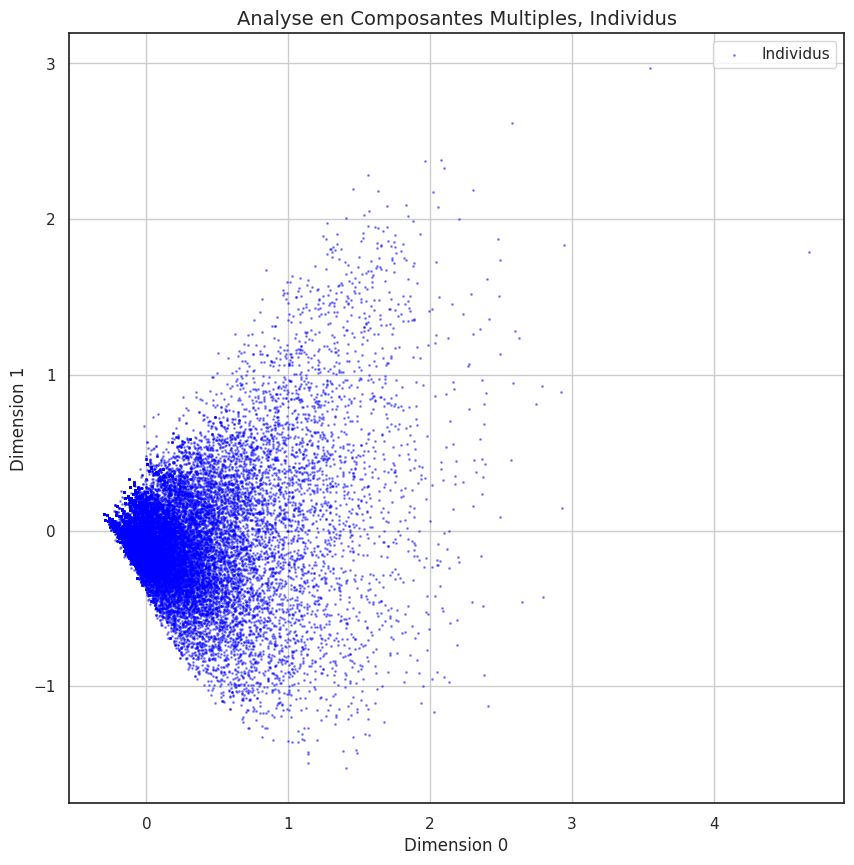

In [77]:
plot_individus = ad.mca_plot_individuals(df_mca, mca)

In [78]:
# Visualisation par groupes
# Le dataframe comporte beaucoup de colonnes => difficile de plotter un graphe à la fois

# Ajouter un coté interactif : l'utilisateur choisi la variable de regroupement qu'il souhaite

var_selector = widgets.Dropdown( # Dropdown : liste avec les options qui s'affiche en cliquant
    df_mca=widgets.fixed(df_mca),  # valeur fixée au préalable, l'utilisateur n'a pas de choix
    mca=widgets.fixed(mca), # valeur fixée au préalable, l'utilisateur n'a pas de choix
    guide = widgets.fixed(guide), # valeur fixée au préalable, l'utilisateur n'a pas de choix
    options=df_mca.columns, # Variable à choisir
    description='Variable:',
    value='BREATHING' # la valeur par défault
)

interactive_plot = widgets.interactive(ad.mca_plot_individuals_group, # la fonction prend 4 paramètres
                    variable=var_selector,
                    df_mca=widgets.fixed(df_mca),
                    mca=widgets.fixed(mca),
                    guide = widgets.fixed(guide))

display(interactive_plot)

interactive(children=(Dropdown(description='Variable:', options=('BREATHING', 'STOMACH', 'TOOTHACHES', 'CAVITI…

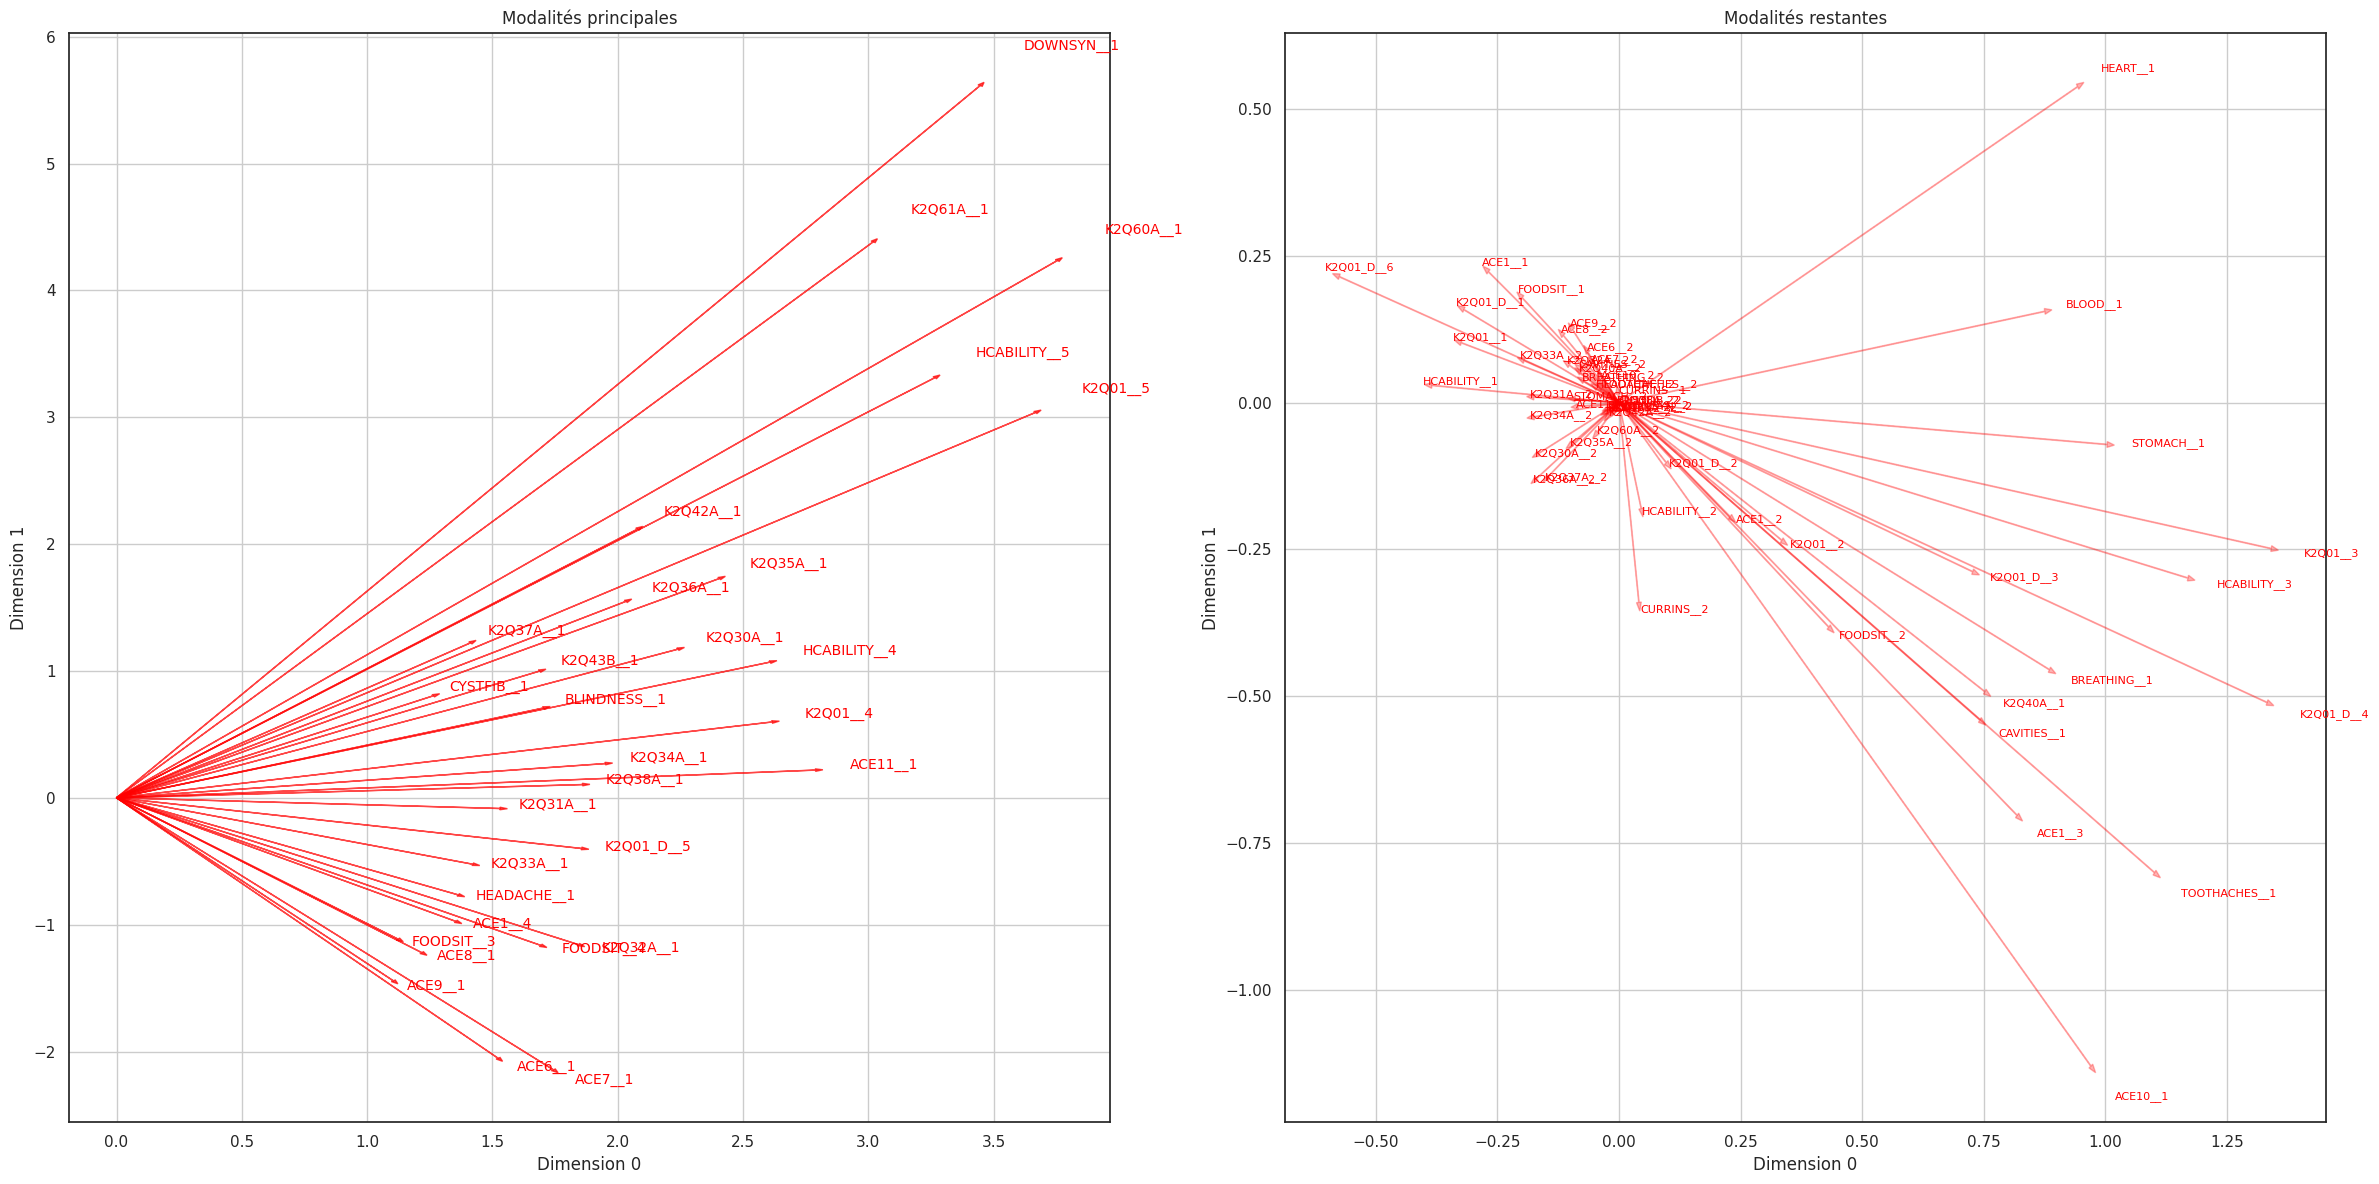

In [79]:
plot_modalites = ad.mca_plot_categories(df_mca, mca, 30)

Beaucoup de cases proche du bleu clair/bleu moyen illustrent des corrélations modestes à modérées, plutôt faibles globalement.
## ANALYSE A REFAIRE - LES VARIABLES ONT CHANGE

De petits îlots rouge‑orangés indiquent quelques paires assez corrélées positivement, par exemple autour de ```ACE11```(To the best of your knowledge, has this child EVER experienced any of the following? Treated or judged unfairly because of a health condition or disability) et ```K2Q60A```(Has a doctor, other health care provider, or educator EVER told you that this child has......Intellectual Disability (formerly known as Mental Retardation?), et plus bas autour de ```FOODSIT```(Which of these statements best describes your household's ability to afford the food you need DURING THE PAST 12 MONTHS?), ```ACE1```(SINCE THIS CHILD WAS BORN, how often has it been very hard to cover the basics, like food or housing, on your family's income?) et ```K8Q34```(DURING THE PAST MONTH, how often have you felt:...Angry with this child?).

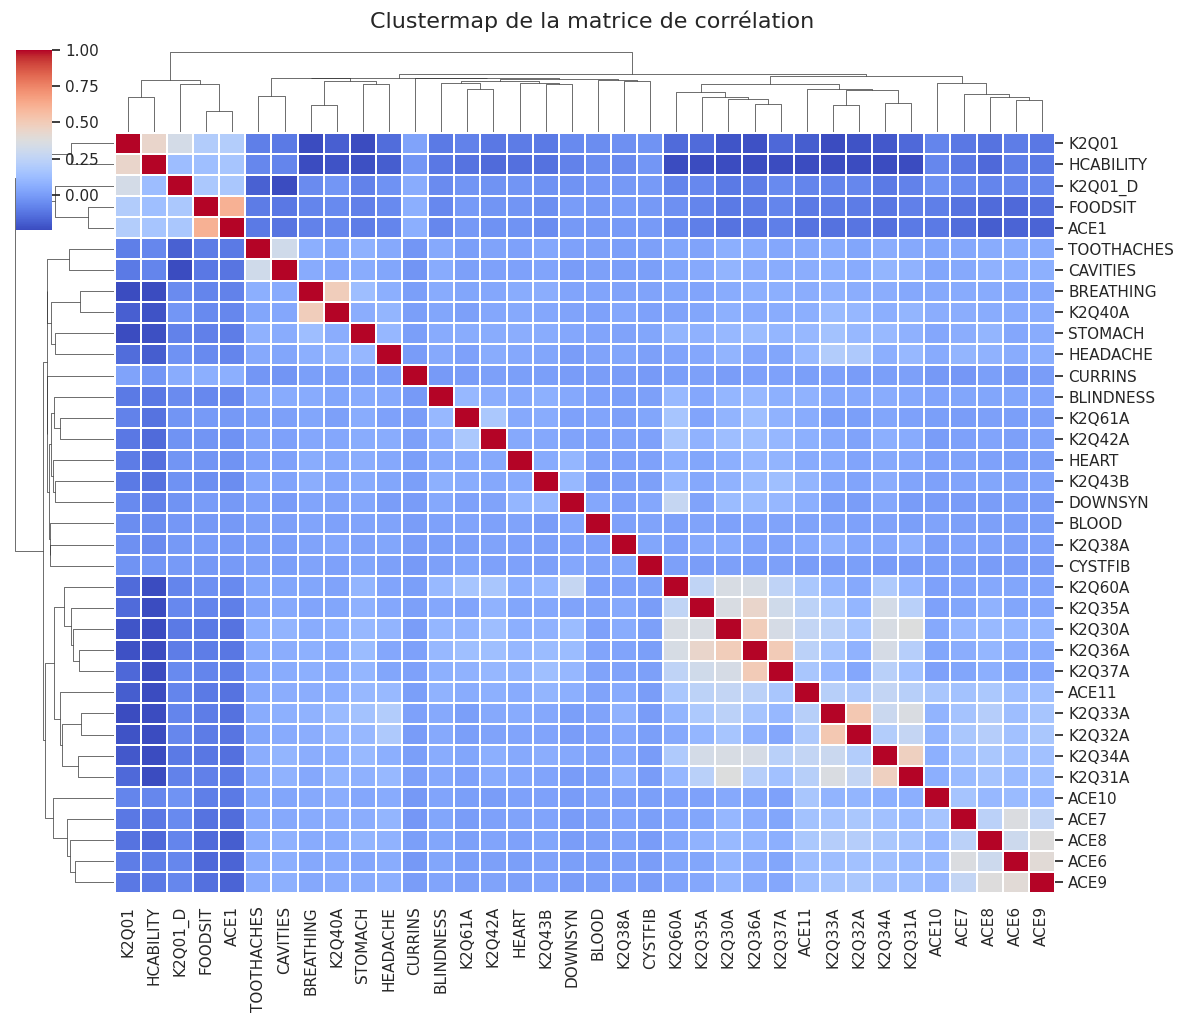

In [80]:
ad.heatmap_generator(df_mca)

## Enrichissement de la base de données

In [81]:
# Enrichissement avec la jointure entre la base économique et la base géographique

df_eco_geo = cd.clean_enrichment_datasets(gdp, gdf)

Dans cette nouvelle base de données économiques, nous remarquons six colonnes vides pour les données de 2024. Le reste de la base ne présente aucune valeur manquante.

### Colonnes manquantes pour 2024
1. `Implicit regional price deflator`
2. `Real PCE (millions of constant (2017) dollars)`
3. `Regional price parities (RPPs)`
4. `Real per capita personal income`
5. `Real personal income (millions of constant (2017) dollars)`
6. `Real per capita PCE`

Suite à l'absence du déflateur des prix au niveau des états, certaines variables ne sont juste pas calculables. Cela arrive surtout dans les bases de données locales ou régionales, où certains indicateurs ne sont pas systématiquement rapportés.

### Colonnes présentes pour 2024
1. Disposable personal income
2. Personal consumption expenditures
3. Per capita personal income
4. Per capita personal consumption expenditures (PCE)
5. Per capita disposable personal income
6. Gross domestic product (GDP)
7. Real GDP (millions of chained 2017 dollars)
8. Personal income
9. Total employment (number of jobs)


In [82]:
missing_values = df_eco_geo.isna().mean().sort_values(ascending=False) * 100
print(missing_values[:10])

2024_Real per capita personal income 4/                               100.0
2024_Real personal income (millions of constant (2017) dollars) 2/    100.0
2024_Real PCE (millions of constant (2017) dollars) 3/                100.0
2024_Real per capita PCE 5/                                           100.0
2024_Regional price parities (RPPs) 9/                                100.0
2024_Implicit regional price deflator 10/                             100.0
2018_Per capita personal consumption expenditures (PCE) 8/              0.0
2018_Per capita disposable personal income 7/                           0.0
2018_Personal consumption expenditures                                  0.0
2018_Personal income                                                    0.0
dtype: float64


# Création d'un indice synthétique annuel de santé au niveau des états

Afin de construire un indice synthétique de santé globale au niveau des états américains, nous allons adopter une méthodologie similaire à celle employée pour calculer l'Indice de Développement Humain. Nous allons calculer 3 sous-indicateurs pour chaque état : un indicateur maladies, un indicateur santé mentale et un indicateur économie-santé. Notre indice de santé globale sera calculée comme la moyenne géométrique de ces 3 indicateurs.

Nos sous-indicateurs seront une moyenne pondérée de ces variables. Afin de construire notre indicateur, notre idée initiale était de réaliser une ACP sur nos variables agrégées par état, et choisir comme
pondération les charges factorielles de chaque variable, i.e la contribution de chaque variable à la première composante de l'ACP. Ce choix est motivé par un désir de choisir une pondération issue des données afin d'éviter une pondération arbitraire. Cependant, comme nous le verrons plus bas, l'ACP ne donne pas de résultats satisfaisants (avec une première composant qui n'explique qu'un quart de la variance expliquée). Nous nous rabattons donc pour éviter de faire des choix plus arbitraires sur une moyenne simple des variables.

## Indicateur pour les maladies : illustration sur l'année 2023

Pour les maladies, nous avons volontairement choisi d'utiliser uniquement les questions sous la forme "Has a doctor or other health care provider EVER told you that this child has..." afin de simplifier l'étude.
Pour construire nos indicateurs, on va agréger ces variables par état grâce à la variable FIPSST.
Notre nouvelle base de données sera une base où les individus seront chaque état, avec les variables ci-dessus en moyenne.
Pour construire un indicateur pertinent (plus l'indicateur est grand, plus la population est saine), on inversera le sens des catégories pour General Health et Teeth description (donc 1 = Poor à 5 = Excellent pour General Health, 0 = Pas de dents à 5 = Excellent pour Teeth description). De même, pour une question de lisibilité, on a remplacé pour les variables binaires 1/2 par 0/1, ou 0 = a la maladie, 1 = ne l'a pas.

In [83]:
df_2021, df_2022, df_2023, df_2024 = (
    dfs_final[str(year)] for year in range(2021, 2025)
)

groups = {"FIPSST", "FWC"}
health_total_vars = list(set(health_vars) | set(groups))

# étape n°1 : Inversion de l'échelle
df_sickness_2023 = df_2023[health_total_vars].copy()
df_sickness_2023[health_category_vars] = 6 - df_sickness_2023[health_category_vars]

# étape n°2 : Inversion des variables binaires
# Transformation : sain = 1, malade = 0
for var in health_bin_vars:
    df_sickness_2023[var] = df_sickness_2023[var] - 1

In [84]:
# Agrégation par état
def weighted_mean(x, w):
    return (x * w).sum() / w.sum()

df_sickness_state_2023 = df_sickness_2023.groupby("FIPSST").apply(
    lambda g: pd.Series({var: weighted_mean(g[var], g["FWC"]) for var in health_vars}))

/tmp/ipykernel_27509/1346569275.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sickness_state_2023 = df_sickness_2023.groupby("FIPSST").apply(


In [85]:
X = df_sickness_state_2023[health_vars]

In [87]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_std = pd.DataFrame(X_std, columns=health_vars, index=df_sickness_state_2023.index)

In [88]:
pca = PCA()
pca.fit(X_std)

explained_variance = pca.explained_variance_ratio_
print("Variance expliquée par PC1 :", explained_variance[0])

Variance expliquée par PC1 : 0.22475405592503298


Nous obtenons une première composante expliquant une part de la variance assez faible, seulement 22% (il aura fallu au moins 4 composantes pour expliquer plus de 50% de la variance). La pondération que nous pouvons en extraire ne présentera donc pas d'avantages comparé à une pondération arbitraire comme une pondération uniforme. Nous choisissons donc une pondération uniforme pour notre indicateur.

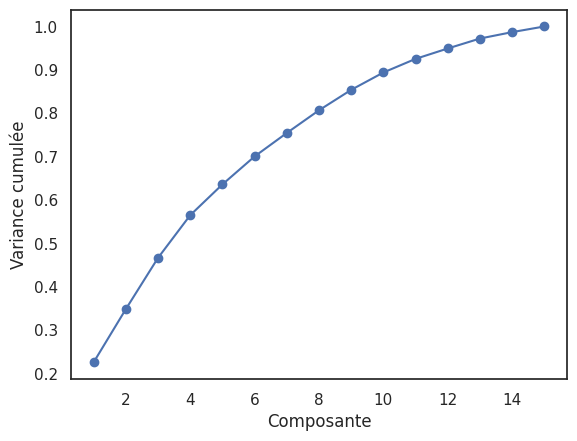

In [89]:
plt.plot(range(1, len(explained_variance)+1), explained_variance.cumsum(), marker='o')
plt.xlabel("Composante")
plt.ylabel("Variance cumulée")
plt.show()

In [90]:
df_sickness_state_2023["sub_indicator_health_2023"] = X.mean(axis=1)

In [91]:
df_sickness_state_2023["sub_indicator_health_2023"].describe()

count    51.000000
mean      1.407074
std       0.009869
min       1.381822
25%       1.399922
50%       1.408343
75%       1.412935
max       1.427930
Name: sub_indicator_health_2023, dtype: float64

Notre indicateur peut prendre des valeurs comprises entre 1/15 = 0.066 (cas où toutes les variables sont au minimum) et 23/15 = 1.533 (en l'occurence ici, l'indicateur est compris entre 1.3 et 1.42 pour les états américains). Nous effectuons une transformation affine, pour le ramener entre 0 et 1 (de façon similaire aux sous-indices utilisés pour le calcul de l'indice de développement humain).

In [92]:
I = df_sickness_state_2023["sub_indicator_health_2023"]

df_sickness_state_2023["sub_indicator_health_2023"] = (I-1/15)/(23/15 - 1/15)
df_sickness_state_2023["sub_indicator_health_2023"]

I.describe()

count    51.000000
mean      1.407074
std       0.009869
min       1.381822
25%       1.399922
50%       1.408343
75%       1.412935
max       1.427930
Name: sub_indicator_health_2023, dtype: float64

## Indicateur pour la santé mentale : illustration sur l'année 2023

In [97]:
mental_heath_indicator_2023 = model.calculate_indicator("2023", dfs_final, "mental_health", 
                                             mental_category_vars, mental_bin_vars,
                                             groups)

/home/onyxia/work/Determinants_of_children-s_health/script/model.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_theme = df_theme.groupby("FIPSST").apply(


In [98]:
mental_heath_indicator_2023.describe()

count    51.000000
mean      0.926280
std       0.008715
min       0.905448
25%       0.919206
50%       0.927559
75%       0.930577
max       0.949192
Name: sub_indicator_mental_health_2023, dtype: float64